# Sustainability Countries in Our World
In this project, our world data is represented in 5 main aspects;
1. Economic
2. Environmental
3. Health
4. Human
5. Political<br><br>

These aspects are combined to create <b>Sustainability</b>. All of aspects will be mainly analyzed in 2 views (<em>Cluster analysis</em> and <em>Index of each aspect comparison</em>) to state how our world is now.

### Import Package and check dataset
Due to data sources are gathered diversely (World Bank, OurWorldinData, etc.), Checking, varifying, and handling with error and missing data is counted in the process. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import missingno as msno
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import gmean

In [2]:
# Load Dataset
worldData = pd.read_csv('datasets/raw_world_source_ana.csv', na_values=["-"], encoding='cp1252')
worldData.iloc[:,3:7].head()

,Ease of doing business score (0 = lowest performance to 100 = best performance),Economic Growth,"Employment to population ratio, 15+, total (%) (modeled ILO estimate)",GDP (current US$)
0,44.06497,-2.35,35.893002,1.478686e+10
1,67.74847,8.54,51.609001,1.825579e+10
2,48.59758,3.85,35.113998,1.630000e+11
3,41.28838,0.70,69.936996,6.740429e+10
4,58.96151,10.26,53.814999,4.870000e+11


In [3]:
# Check dimensions of it
worldData.shape

(174, 89)

Now dataset has 89 features and 174 instances.

Country                                                                            0
ISO Country code                                                                   0
Continent                                                                          0
Ease of doing business score (0 = lowest performance to 100 = best performance)    4
Economic Growth                                                                    7
                                                                                  ..
Political Rights Score                                                             0
Political Stability & Absence Of Violence                                          1
Regulatory Quality                                                                 1
Rule Of Law                                                                        1
UHC service coverage index                                                         2
Length: 89, dtype: int64

<AxesSubplot:>

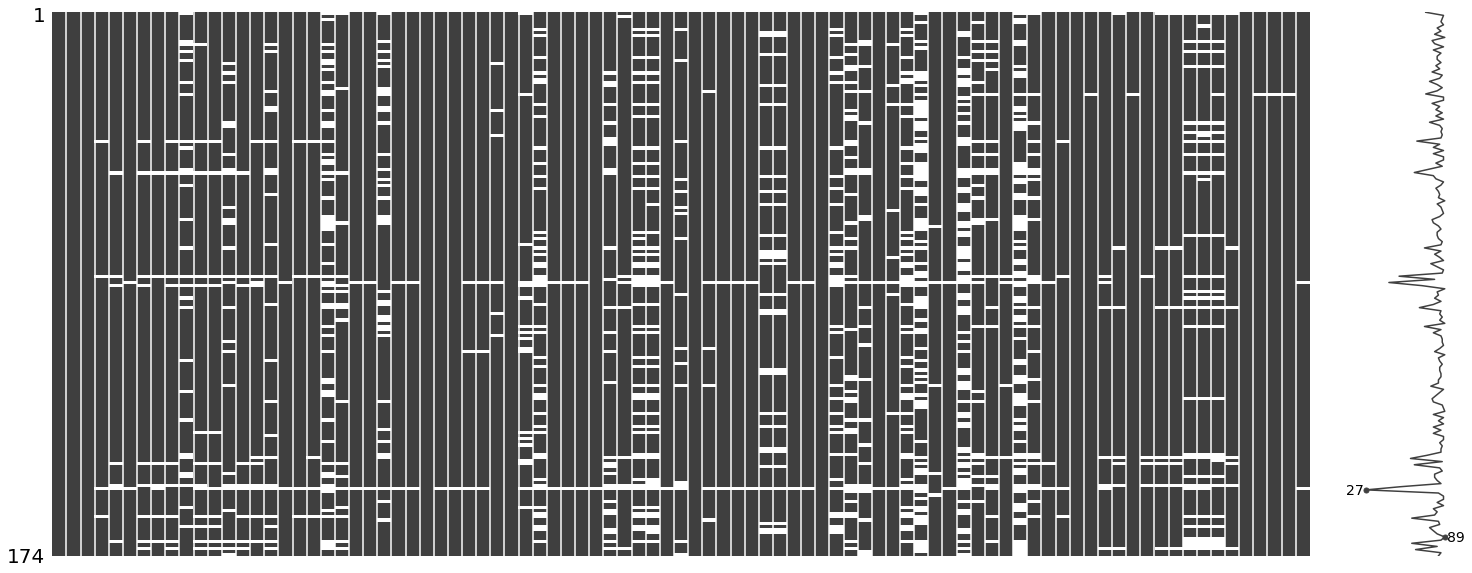

In [4]:
# Check NA data
display(worldData.isna().sum())

# Check with missing matrix plot
msno.matrix(worldData)

### Imputation

As can be seen, there are approximate 1 in 3 of data are missing values and this is a crucial struggle to do cluster analysis.<br><br>

Hence, Imputation method plays a role now by using <b>Multiple Imputations by Chained Equation (MICE)</b> to fill in missing values by an inclination data from the rest of features left.

In [5]:
def into_the_unknown(DataFrame, scaler, Imputer):
    # Imputation with copied dataframe imputing with MICE: worldDataMICE
    imputedDataFrame = DataFrame.iloc[:,3:].copy(deep = True)

    # Scaling data
    scalingImputedDataFrame = scaler.fit_transform(imputedDataFrame)

    # Imputing data to copied dataframe
    imputedDataFrame.iloc[:,:] = Imputer.fit_transform(scalingImputedDataFrame)

    # Invere transform data
    imputedDataFrame = scaler.inverse_transform(imputedDataFrame)

    # Convert data to DataFrame
    imputedDataFrame = pd.DataFrame(imputedDataFrame)

    return imputedDataFrame

In [6]:
worldDataMICE = into_the_unknown(worldData, MinMaxScaler(), IterativeImputer(min_value=0 ,max_value=1))

C:\Program Files\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
worldDataMICE.to_csv('datasets/world_source_ana_MICEimputed.csv', encoding='UTF-8')

### Calculating Indexes and Cluster Analysis

After finished imputating data, the next step is calculating index of each aspect and analyzing cluster analysis by tSNE following below;
1. Calculating index for each aspect
2. Using average of index of each aspect to classify a country class. For any countries that have index more than the average, they will be classified as <b>High class</b>. The otherwise is classified as <b>Low class</b>.
3. Use numerical features <em>except indexes</em> to do cluster analysis with tSNE.<br><br>

Note: <em>tSNE (t-distribution Stochastic Neighbor Embedding)</em> is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. <em>(Laurens van der Maaten)

In [100]:
# Load world_source_ana_MICEimputed and Factors: df, factors
df = pd.read_csv('data_for_dev/without_tsne_and_indexed/world_data_imputed.csv', encoding='cp1252')
factors = pd.read_csv('data_for_dev/without_tsne_and_indexed/factors.csv')
# Assign features to factors
Factors = ['Economic', 'Environment', 'Health', 'Human', 'Politic']

display(df[list(factors[(factors['Factor'] == Factors[2]) & (factors['Direction'] == 'D')]['Columns'])].head())
factors['Factor'].unique()

,health expenditure % of GDP,health expenditure per person,"Life expectancy at birth, total (years)",Population
0,3.21,65.800000,62.575,40099462
1,3.92,929.759051,76.989,2811666
2,6.10,248.200000,74.453,44177969
3,2.42,71.300000,62.261,34503774
4,4.72,946.000000,75.892,45808747


array(['Economic', 'Environment', 'Health', 'Human', 'Politic'],
      dtype=object)

In [101]:
# Check how many features of each aspect
dict(zip(Factors, [len(factors[factors['Factor'] == i]['Columns']) for i in Factors]))

{'Economic': 19, 'Environment': 12, 'Health': 27, 'Human': 11, 'Politic': 17}

Before calculating indexes and doing any analysis, data must be normalized by normalization method (transforming data into range 0-1). Here are 2 things to take care of
1. Direction of a feature before normalization; Not all features have the similar trend as expected e.g. higher of mortality rate (Infant), incidence of HIV ages 15-49 or CO2 emission value do not mean representing in a good way.
2. After normalization, data MUST NOT BE 0; all we know is transforming data into range 0-1. Nonetheless, these normalized data will generate index by using <b>Geometric mean</b>; which is multiple of all feature values for each instance. Hence, data need to be adjusted for this purpose.

Create <b>functions</d> for transforming and adjusting data

In [17]:
# Normalization function
def normData(df, directedCols, undirectedCols):
    # Function for directed features
    def dNorm(data):
        # Adjusted value
        a = 0.0000001
        Min = data.min(axis = 0, skipna = True) - a
        Max = data.max(axis = 0, skipna = True)
        dNormDf = (data - Min)/(Max - Min)
        return dNormDf
    # Function for indirected features
    def udNorm(data):
        # Adjusted value
        a = 0.0000001
        Min = data.min(axis = 0, skipna = True) 
        Max = data.max(axis = 0, skipna = True) + a
        udNormDf = 1- (data - Min)/(Max - Min)
        return udNormDf
    
    # Calculating normalization
    dNorm_ = dNorm(df[directedCols])
    udNorm_ = udNorm(df[undirectedCols])

    # Send output as DataFame
    dataNorm = pd.concat([dNorm_, udNorm_], axis = 1)
    return dataNorm

# Index and class generation function
def index_class(df, Factor):
    # TSNE for visualization each factor
    data = normData(df, list(factors[(factors['Factor'] == Factor) & (factors['Direction'] == 'D')]['Columns']),
    list(factors[(factors['Factor'] == Factor) & (factors['Direction'] == 'I')]['Columns']))

    # If any datapoint is 0, replace with 0.0000001
    data = data.replace(0,0.0000001)

    # Find index by geometric mean
    data[Factor+'Index'] = data.apply(gmean,axis = 1)

    # Find average for creating data class
    Mean = data[Factor+'Index'].mean()
    data.loc[data[Factor+'Index'] >= Mean,Factor+'Class'] = 'High'
    data.loc[data[Factor+'Index'] < Mean, Factor+'Class'] = 'Low'
    
    return data

In [102]:
# Transform and adjust dataset
dataFrame = [index_class(df, Factor) for Factor in Factors]

In [87]:
# Get name of country and continent for colour in data visualization
country = df['Country'].values
continent = df['Continent']

In [88]:
# Run the model for all data
Tsne_name = ['tsne_eco', 'tsne_env', 'tsne_hel', 'tsne_hum', 'tsne_pol']
Tsne = []
X = []
Y = []

for index in range(len(Tsne_name)):
    values = dataFrame[index].iloc[:,:-2].values

    model = TSNE(learning_rate = 100, perplexity=50)
    tsne_features = model.fit_transform(values)

    xs = tsne_features[:,0]
    ys = tsne_features[:,1]

    Tsne.append(tsne_features)
    X.append(xs)
    Y.append(ys)

When complete cluster analysis for all aspects, use all 5 indexes to calculate <b>Sustainability index and clustering</b>.

In [89]:
dfCombine = pd.concat([dataFrame[0]['EconomicIndex'], dataFrame[1]['EnvironmentIndex'], 
dataFrame[2]['HealthIndex'], dataFrame[3]['HumanIndex'], dataFrame[4]['PoliticIndex']], axis = 1)

In [109]:
dfALL = normData(df, list(factors[factors['Direction'] == 'D']['Columns']),
list(factors[factors['Direction'] == 'I']['Columns']))

dfALL['AllIndex'] = dfCombine.mean(axis=1)

Mean = dfALL['AllIndex'].mean()
dfALL.loc[dfALL['AllIndex'] >= Mean,'AllClass'] = 'High'
dfALL.loc[dfALL['AllIndex'] < Mean, 'AllClass'] = 'Low'

# Add 'All' in lists
dataFrame.append(dfALL)
Factors.append('All')

In [110]:
values = dfALL.iloc[:,:-2].values

model = TSNE(learning_rate = 100, perplexity=50)
tsne_All = model.fit_transform(values)

xs = tsne_All[:,0]
ys = tsne_All[:,1]

Tsne.append(tsne_All)
X.append(xs)
Y.append(ys)

Check parameters in the model

In [111]:
display((model.learning_rate_, model.perplexity, model.method, model.n_iter_, model.n_features_in_))

(100, 50, 'barnes_hut', 799, 86)

### Data visualization

Plot a scatter plot of  interesting aspect clustering. 

In [112]:
# Plot with plotly
# {0: Economic, 1: Environment; 2: Health, 3: Human, 4: Politic, 5: All}
i = 5
fig = px.scatter(x = X[i], y = Y[i], color = dataFrame[i].iloc[:,-1],  hover_name=country, 
                template = 'seaborn', width = 800, height = 500
                )

fig.show()

Plot a bee swarm plot to check how all countries indexes are arranged.

In [113]:
fig = px.strip(y = dataFrame[i].iloc[:,-2], color = dataFrame[i].iloc[:,-1],  hover_name=country, 
                template = 'seaborn', width = 800, height = 500
                )

fig.show()

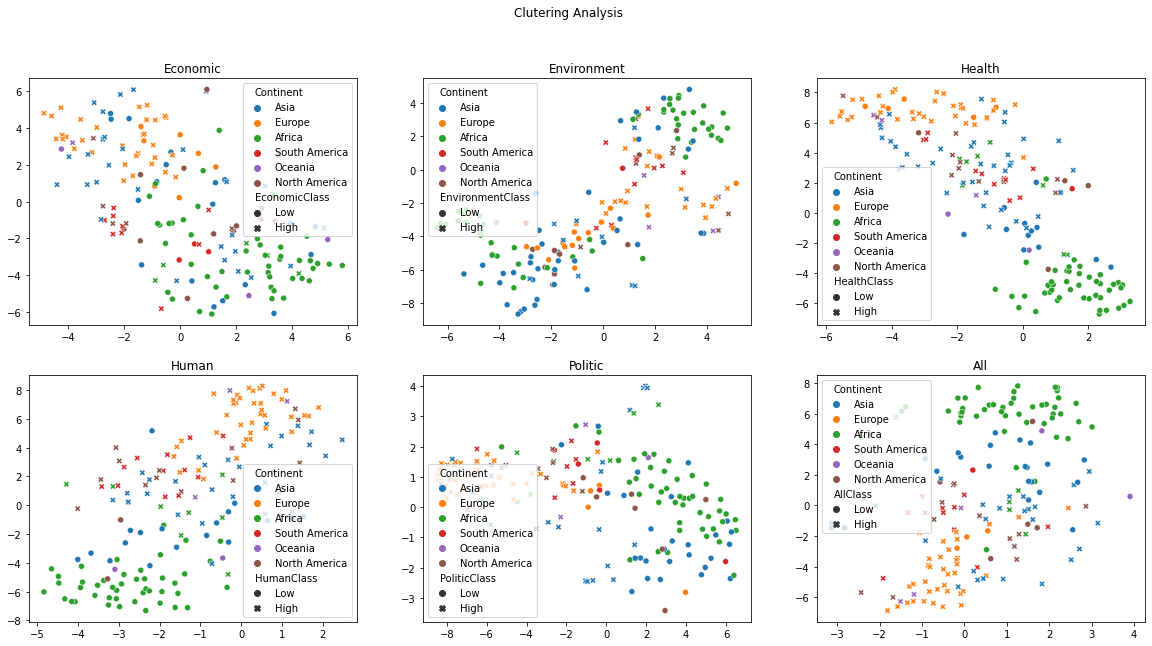

In [114]:
fig, axes = plt.subplots(2,3, figsize = (20,10))
fig.suptitle('Clutering Analysis')

for row in range(2):
    for col in range(3):
        if(row != 1):
            axes[row,col].set_title(Factors[col+row])
            sns.scatterplot(ax = axes[row,col], x = X[col+row], y = Y[col+row], style = dataFrame[col+row].iloc[:,-1], hue = continent)
        else:
            axes[row,col].set_title(Factors[col+row+2])
            sns.scatterplot(ax = axes[row,col], x = X[col+row+2], y = Y[col+row+2], style = dataFrame[col+row+2].iloc[:,-1], hue = continent)
plt.savefig("plot/cluster.svg")

### Export data and etc.

In [ ]:
for n, m in zip(Tsne_name, Tsne):
    pd.DataFrame(m).to_csv('TSNE/'+n+'.csv', index = False)

In [ ]:
nameIndex = ['datasets/indexes/indexECO.csv', 'datasets/indexes/indexENV.csv', 'datasets/indexes/indexHEL.csv', 'datasets/indexes/indexHUM.csv', 'datasets/indexes/indexPOL.csv', 'datasets/indexes/indexALL.csv']

for d, n in zip(dataFrame, nameIndex):
    pd.DataFrame(d.iloc[:,-2:]).to_csv(n, index = False)

In [ ]:
tsne_and_index = [pd.concat([pd.DataFrame(Tsne[i]),dataFrame[i].iloc[:,-2:]], axis = 1) for i in range(6)]

In [ ]:
tsne_and_indexes = pd.concat(tsne_and_index, axis = 1)

In [ ]:
tsne_and_indexes.to_csv('data_for_dev/tsne_and_indexes.csv', index = False)

In [ ]:
# Combine dataframe from split factor df
DF = [df[list(factors[factors['Factor'] == Factors[i]]['Columns'])] for i in range(len(Factors))]

worldFactor = pd.concat(DF, axis = 1)

In [ ]:
worldFactor.to_csv('data_for_dev/world_data.csv', index = False)